# Laser Ablation Data Reduction in Python part 2: 
## Calculating concentrations from LA-ICP-MS data
***Jordan Lubbers***<br>
*W.M. Keck Collaboratory for Plasma Spectrometry* <br>
*College of Earth, Ocean, and Atmospheric Sciences* <br>
*Oregon State University* <br>



We can calculate a concentration of analyte ($i$) in an unknown material ($u$) using the following relationship from [Longerich et al., (1996)](https://pubs.rsc.org/en/content/articlepdf/1996/ja/ja9961100899?casa_token=wzlsHfnX2isAAAAA:9eacDWSUwCiphCgC6M2ojwehw8yItKjyC1bnnOowEEKO1XWjPMdAY3fRfvRzWL6BtypMdmMrrBWJupkQ):

$$\Large{{C_i}^u = \frac{{R_i}^u}{S} }$$

Where ${C_i}^u$ and ${R_i}^u$ are the concentration of analyte and count rate of analyte ($i$) in the unknown material, respectively, and $S$ is the normalized sensitivity. When using naturally occuring internal standards, $S$ can be defined as:

$$ \Large{S = \frac{{R_i}^{std}}{{C_i}^{std}}\left[\frac{{R_{n}}^u}{{R_{n}}^{std}} \frac{{C_{n}}^{std}}{{C_{n}}^{u}} \right]  }$$

Where ${R_i}^{std}$ and ${C_i}^{std}$ are the count rate and and concentration of analyte ($i$) in the calibration standard, ${R_{n}}^u$ and ${R_{n}}^{std}$ are the count rates of the internal standard in the unknown material and calibration standard, ${C_{n}}^{u}$ and ${C_{n}}^{std}$ are the concentrations of the internal standard in the unknown material and calibration standard. 

[Kent and Ungerer (2006)](https://pubs.geoscienceworld.org/msa/ammin/article-abstract/91/8-9/1401/134304/Analysis-of-light-lithophile-elements-Li-Be-B-by?redirectedFrom=fulltext) re-arrange this relationship such that the count rate expressions always containin unknown analytes in the numerator:

$$\Large{ {C_i}^u = {C_n}^u \frac{\left[\frac{{C_i}^{std}}{{C_n}^{std}}\right]}{\left[\frac{{R_i}^{std}}{{R_n}^{std}}\right]}\frac{{R_i}^u}{{R_{n}}^u}} $$ 


Below we will walk through how to do this "by hand" in python. The data have already had their count rate ratios calculated and the analyte used as the internal standard will be listed in the ```norm``` column of the input data. Data from the W.M Keck Collaboratory for Plasma Spectrometry at Oregon State University commonly uses $^{43}Ca$ or $^{29}Si$ for silicate minerals.


In [1]:
import re

# matplotlib defaults
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.tools.eval_measures import rmse

sys.path.insert(1, r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\Python_scripts")
import mpl_defaults

plt.rcParams["font.sans-serif"] = "CMU Sans Serif"


outpath = r"C:\Users\jlubbers\OneDrive - DOI\Desktop\test_figures"

# Import data

Here we bring in our spreadsheet with data that has been normalized to an internal standard as well as a spreadsheet with [GEOREM](http://georem.mpch-mainz.gwdg.de/sample_query_pref.asp) preferred values for all of the standards used in the lab. We set the index to be each spot so that we can access a given analyte for any spot using standard pandas notation:
```python
#grab the normalized 48Ti value for spot BCR-2G_23
test_data.loc['BCR-2G_23','48Ti']

#grab all of the normalized ratios and their uncertainties for spot BCR-2G_23
test_data.loc['BCR-2G_23',:]

```
### Data location
Data used here can be found [here](https://github.com/jlubbersgeo/laserTRAM-DB/tree/main/tests) folder and is titled ```spot_test_lasertram_complete.xlsx``` and ```laicpms_stds_tidy.xlsx``` for unknown and published standard data, respectively.

In [3]:
# import published standards data
stds_data = pd.read_excel(
    r"C:\Users\jlubbers\OneDrive - DOI\Research\Coding\laser_processing\laserTRAM-DB\tests\laicpms_stds_tidy.xlsx"
).set_index("Standard")


test_data = (
    pd.read_excel(
        r"C:\Users\jlubbers\OneDrive - DOI\Research\Mendenhall\Data\laser_data\B4 Caldera Project\run1\run1_LT_complete_29si_redo.xlsx"
    )
    .dropna()
    .set_index("Spot")
)

test_data.insert(loc=0, column="index", value=np.arange(1, len(test_data) + 1))
test_data.head()

,index,timestamp,bkgd_start,bkgd_stop,int_start,int_stop,norm,norm_cps,7Li,29Si,...,153Eu_se,157Gd_se,163Dy_se,166Er_se,172Yb_se,178Hf_se,181Ta_se,208Pb_se,232Th_se,238U_se
Spot,,,,,,,,,,,,,,,,,,,,,
GSD-1G_-_1,1,2022-05-09 19:55:59.000000,5.13587,15.01534,25.26088,41.36167,29Si,4.428457e+06,0.009235,1,...,1.478866,1.833357,1.586812,1.519495,1.578589,1.797862,1.572377,1.762530,1.683019,1.502838
GSD-1G_-_2,2,2022-05-09 19:57:45.999999,5.13634,15.01707,28.19087,45.02408,29Si,4.042539e+06,0.008866,1,...,1.581653,1.426963,1.532621,1.479009,1.643662,1.405610,1.350416,1.359451,1.340050,1.256175
GSE-1G_-_1,3,2022-05-09 19:58:38.000000,5.13620,15.01625,22.33507,39.16801,29Si,4.383596e+06,0.088433,1,...,1.206619,1.093657,1.139264,1.194288,1.195928,1.120309,1.096936,1.189750,1.032851,1.028852
GSE-1G_-_2,4,2022-05-09 20:03:56.000001,5.13615,15.01624,22.33482,39.16714,29Si,3.978044e+06,0.088166,1,...,1.248182,1.262288,1.303387,1.335031,1.355737,1.360555,1.292409,1.536178,1.291566,1.405033
ATHO-G_-_1,5,2022-05-09 20:04:53.000000,5.13646,15.01659,22.33569,39.16858,29Si,5.221175e+06,0.004256,1,...,2.488578,1.925663,1.660312,1.632085,2.229320,1.578215,1.645301,1.748852,1.431874,2.064947


## Get analysis info
- spots
- possible calibration standards
- experiment analytes

In [4]:
myspots = test_data.index.unique().tolist()
pubstandards = stds_data.index.unique().tolist()
# list of columns that pertain to analytes
myanalytes = [
    analyte
    for analyte in test_data.columns.tolist()
    if not (
        "_se" in analyte
        or "_SE" in analyte
        or "norm" in analyte
        or "index" in analyte
        or "start" in analyte
        or "stop" in analyte
        or "long" in analyte
        or "timestamp" in analyte
    )
]
myanalytes.remove(test_data["norm"].unique()[0])
# list of columns that pertain to analyte uncertainties
myuncertainties = [analyte + "_se" for analyte in myanalytes]

# Calibration Standard
For this experiment we will use BCR-2G as our calibration standard. Therefore we want to check where in our dataframe samples are BCR-2G analyses and save them as their own dataframe. We then get the average, standard deviation, and relative standard error. 

Below we plot how the normalized ratio for each element changes through time for our calibration standard. While little to no variation is ideal, small changes may be present due to small heterogeneities in standard material composition or drift in the mass spectrometer. 

In [5]:
# Check for potential calibration standards. This will let us know what our options
# are for choosing calibration standards by looking for spots that have the same string
# as the standard spreadsheet


stds_column = [[std for std in pubstandards if std in spot] for spot in myspots]

stds_column = [["unknown"] if not l else l for l in stds_column]

stds_column = [std for sublist in stds_column for std in sublist]

# all standards that have more than 1 analysis and can
# therefore be used as a calibration standard
potential_standards = [
    std for std in np.unique(stds_column) if stds_column.count(std) > 1
]
potential_standards.remove("unknown")

# all of the samples in your input sheet that are NOT potential standards
all_standards = list(np.unique(stds_column))
all_standards.remove("unknown")

# This now denotes whether or not something is a standard
# or an unknown
test_data["sample"] = stds_column

test_data.reset_index(inplace=True)
test_data.set_index("sample", inplace=True)


print("Your potential calibration standards are:")
for standard in potential_standards:
    print(standard)

Your potential calibration standards are:
ATHO-G
BCR-2G
GSD-1G
GSE-1G
NIST-612


In [6]:
# Choosing our calibration standard
calib_std = "GSD-1G"

# create a separate dataframe for our calibration standard data
calib_std_data = test_data.loc[calib_std, :]

In [7]:
# Calibration standard information
# mean
calib_std_means = calib_std_data.loc[:, myanalytes + myuncertainties].mean()
# std deviation
calib_std_stds = calib_std_data.loc[:, myanalytes + myuncertainties].std()
# relative standard error
calib_std_ses = 100 * (
    (calib_std_stds / calib_std_means) / np.sqrt(calib_std_data.shape[0])
)

In [8]:
# Get a list of all of the elements supported in the published standard datasheet
# Get a second list for the same elements but their corresponding uncertainty columns
standard_elements = [
    analyte for analyte in stds_data.columns.tolist() if not ("_std" in analyte)
]
standard_uncertainties = [analyte + "_std" for analyte in standard_elements]

# Drift correction
To check for drift in calibration standard normalized ratios over time, a linear regression is applied to each analyte where the dependent variable is the count rate normalized to the internal standard and the independent variable is the analysis number (i.e., the green lines in the below figure):

$$ \Large{{N_i}^{std} = m_ix + b_i}$$

where $m$ is the regression slope, $x$ is the analysis number, and $b$ is the intercept for analyte $i$. We determine the significance of each regression by evaluating following null hypothesis: $H_0: m_i = 0$ that states that there is no relationship between a given analyte's internal standard normalized ratio and time. We reject this if both the p-value for the coefficient (i.e., slope) is significant and the F-statisic is greater than the critical F value. We set the alpha value for p-value significance at .01 in an effort to mitigate drift correcting all but the most linear of changes, but this may be changed by the user. If the null hypothesis for a given analyte is rejeceted, the analyte is linearly corrected for drift and the regression parameters (e.g., slope and intercept) are used to calculate a normalized countrate for the calibration standard at the point in time where an unknown was analyzed: 


$$\Large{ {C_i}^u = {C_n}^u \frac{\left[\frac{{C_i}^{std}}{{C_n}^{std}}\right]}{\left[m_ix +b_i\right]}\frac{{R_i}^u}{{R_{n}}^u}} $$ 

Uncertainties for the calibration standard then utilize the calculated RMSE rather than the standard error of the mean.




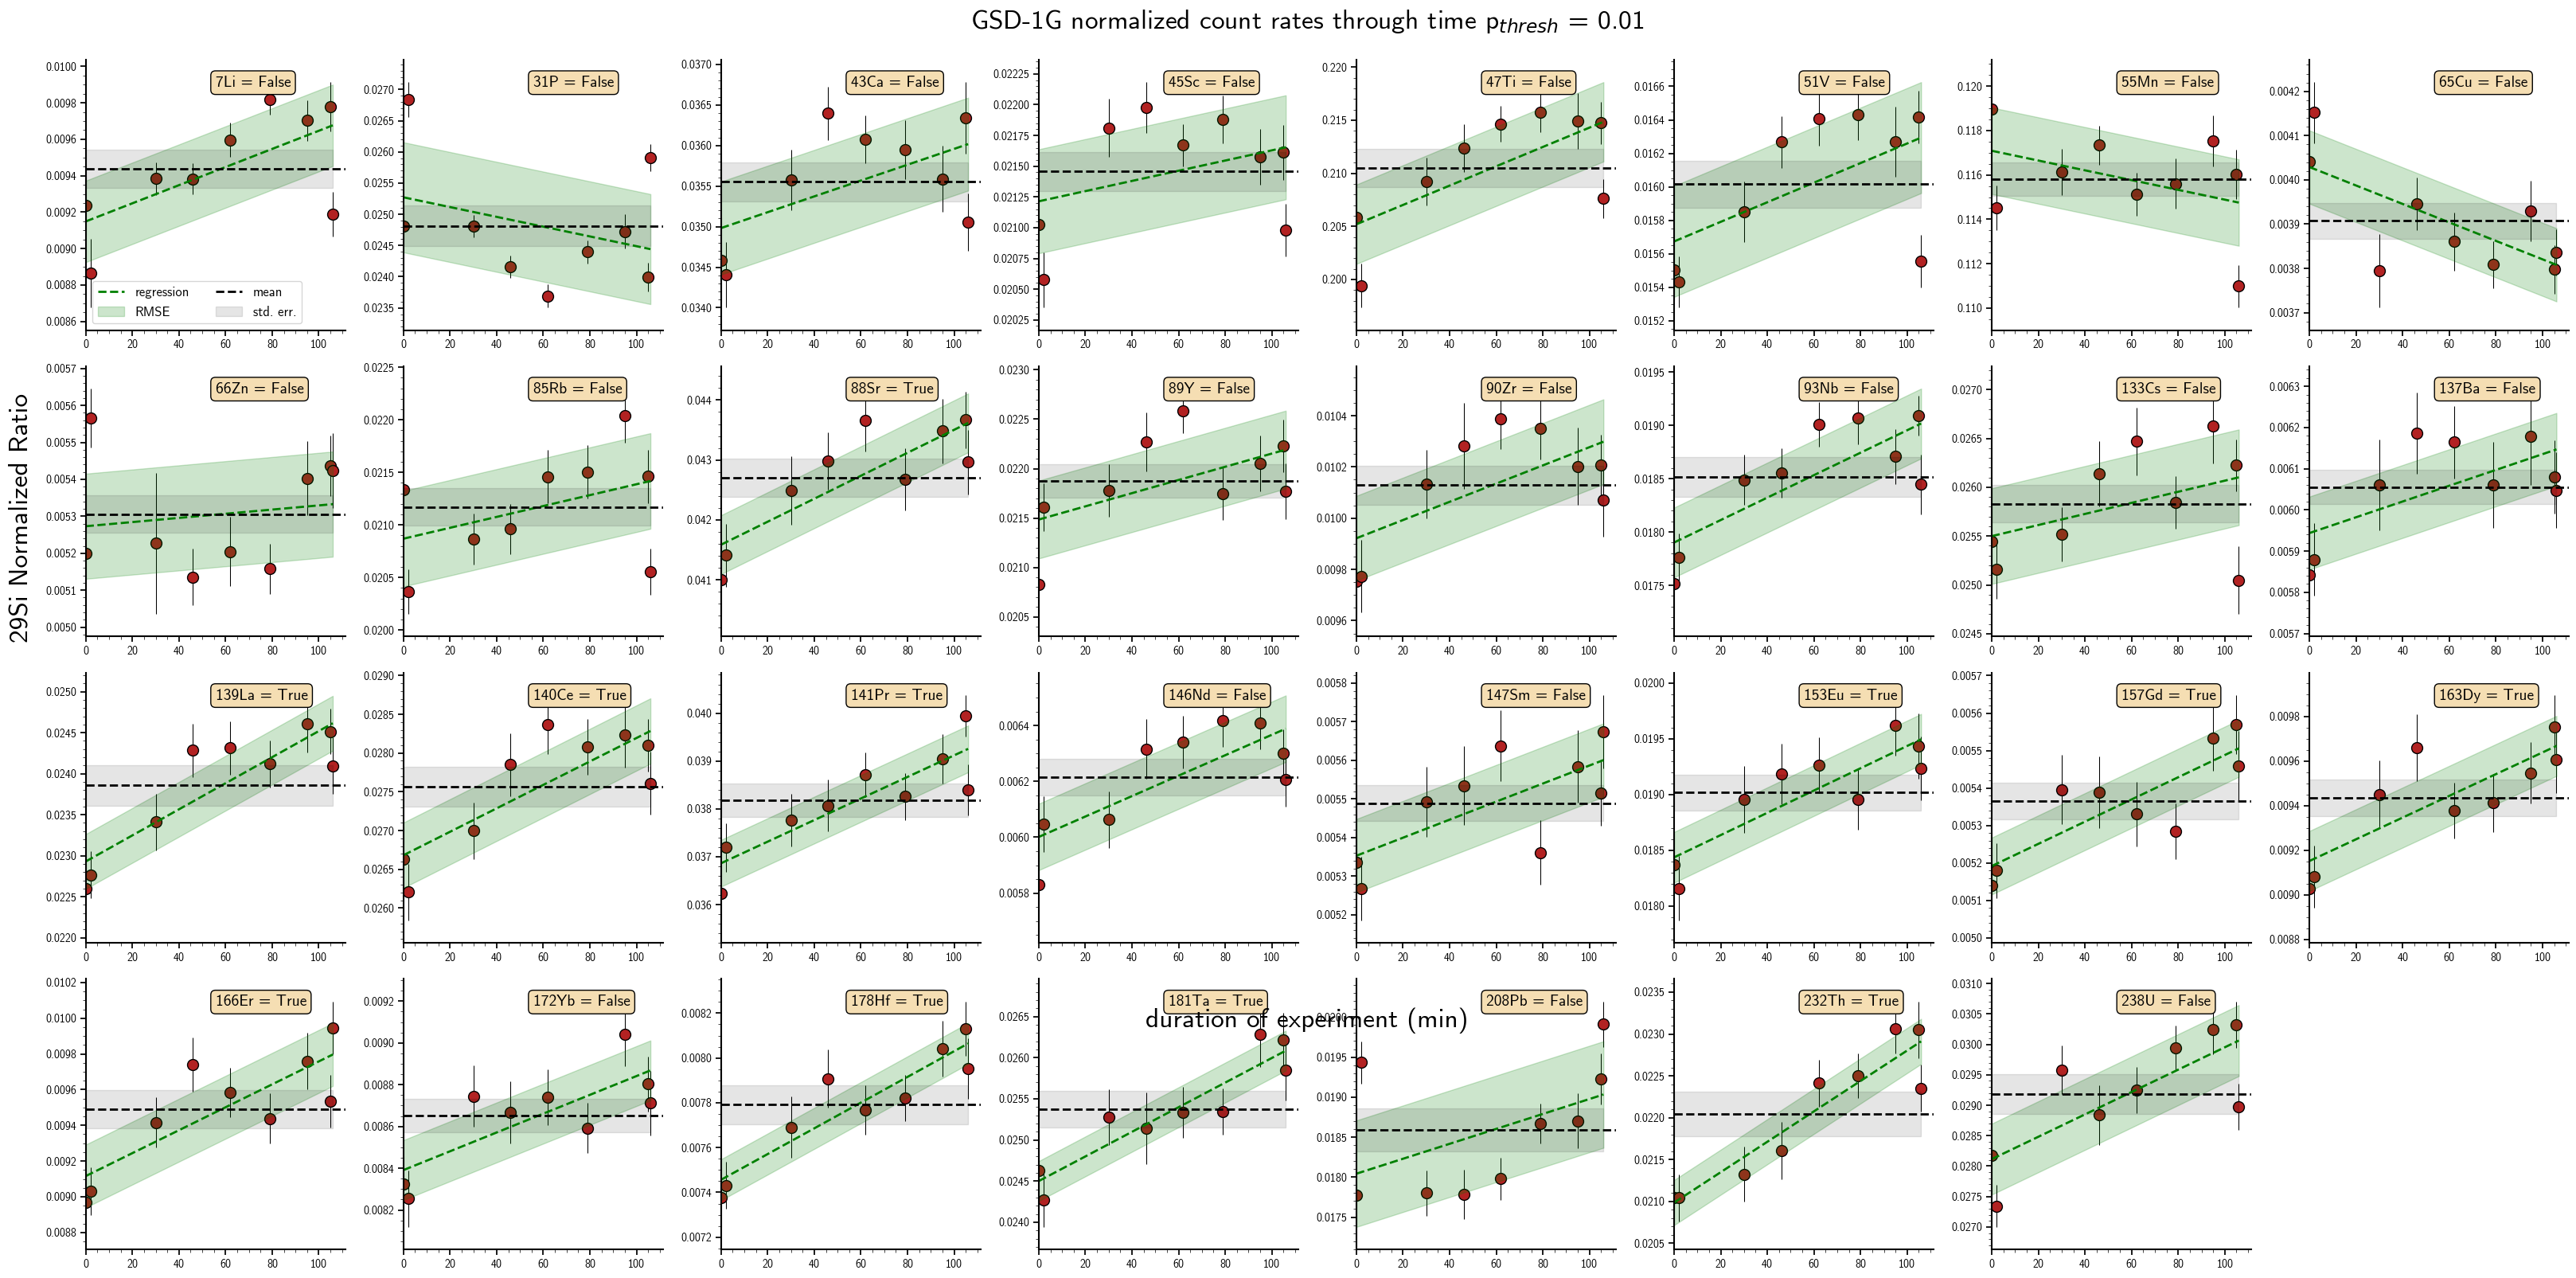

In [9]:
calib_std_rmses = []
calib_std_slopes = []
calib_std_intercepts = []
drift_check = []

# For our calibration standard, calculate the concentration ratio of each analyte to the element used as the internal standard
std_conc_ratios = []
myanalytes_nomass = []

fig, ax = plt.subplots(
    4, int(len(myanalytes) / 4) + 1, figsize=((int(len(myanalytes) / 4) + 1) * 4, 16)
)


axes = ax.ravel()

props = dict(boxstyle="round", facecolor="wheat", alpha=1)
for j in range(len(myanalytes)):

    # Getting regression statistics on analyte normalized ratios through time
    # for the calibration standard. This is what we use to check to see if it needs
    # to be drift corrected
    if "timestamp" in calib_std_data.columns.tolist():
        # get an array in time units based on timestamp column. This is
        # is in seconds
        x = np.array(
            [np.datetime64(d, "m") for d in calib_std_data["timestamp"]]
        ).astype(np.float64)
        # x = np.cumsum(np.diff(x))
        # x = np.insert(x, 0, 0).astype(np.float64)

    else:

        x = calib_std_data["index"]

    # x = calib_std_data["index"]
    y = calib_std_data[myanalytes[j]]

    X = sm.add_constant(x)
    # Note the difference in argument order
    model = sm.OLS(y, X).fit()
    # now generate predictions
    ypred = model.predict(X)

    # calc rmse
    RMSE = rmse(y, ypred)

    calib_std_rmses.append(RMSE)

    if model.params.shape[0] < 2:
        calib_std_slopes.append(model.params[0])
        calib_std_intercepts.append(0)

    else:

        calib_std_slopes.append(model.params[1])
        calib_std_intercepts.append(model.params[0])

    axes[j].plot(np.cumsum(np.diff(x, prepend=x[0])), ypred, "g--", label="regression")
    axes[j].set_xlabel("", fontsize=20)
    axes[j].fill_between(
        np.cumsum(np.diff(x, prepend=x[0])),
        ypred + RMSE,
        ypred - RMSE,
        color="green",
        alpha=0.2,
        label="RMSE",
    )
    axes[j].axhline(y=calib_std_means[j], ls="--", c="k", marker="", label="mean")
    axes[j].fill_between(
        np.cumsum(np.diff(x, prepend=x[0])),
        calib_std_means[j] + calib_std_stds[j] / np.sqrt(calib_std_data.shape[0]),
        calib_std_means[j] - calib_std_stds[j] / np.sqrt(calib_std_data.shape[0]),
        color="black",
        alpha=0.1,
        label="std. err.",
    )

    axes[j].errorbar(
        np.cumsum(np.diff(x, prepend=x[0])),
        y,
        yerr=calib_std_data[myanalytes[j]]
        * (calib_std_data["{}_se".format(myanalytes[j])] / 100),
        fmt="o",
        mfc="firebrick",
        mec="k",
        ecolor="k",
        elinewidth=0.75,
        zorder=0,
        ms=10,
    )
    if j == 0:
        axes[j].legend(loc="lower left", fontsize=12, ncol=2)

    axes[j].set_xlim(0)

    # new stuff
    # confidence limit 99%
    alpha = 0.01
    # f value stuff
    fvalue = model.fvalue
    f_pvalue = model.f_pvalue
    fcrit = stats.f.ppf(q=1 - alpha, dfn=len(x) - 1, dfd=len(y) - 1)
    if (f_pvalue < alpha) and (fvalue > fcrit):
        drift = "True"
        drift_check.append(drift)
    else:
        drift = "False"
        drift_check.append(drift)

    axes[j].text(
        0.5,
        0.9,
        "{} = {}".format(myanalytes[j], drift),
        transform=axes[j].transAxes,
        bbox=props,
        fontsize=14,
    )


for j in range(len(axes)):
    if j >= len(myanalytes):
        fig.delaxes(axes[j])
    mpl_defaults.left_bottom_axes(axes[j])

fig.suptitle(
    "{} normalized count rates through time p$_{{thresh}}$ = {}".format(
        calib_std, alpha
    ),
    fontsize=24,
    y=1,
)
fig.text(
    0.5, 0.2, "duration of experiment (min)", ha="center", fontsize=24,
)
fig.text(
    -0.01,
    0.6,
    "{} Normalized Ratio".format(calib_std_data["norm"].unique()[0]),
    va="center",
    rotation="vertical",
    fontsize=24,
)

fig.tight_layout()
# plt.savefig('{}\drift_correction_check_{}.png'.format(outpath,calib_std),bbox_inches = 'tight')

In [10]:
# For our calibration standard, calculate the concentration ratio of each analyte to the element used as the internal standard
std_conc_ratios = []
myanalytes_nomass = []

for i in range(len(myanalytes)):
    # strip the atomic number from our analyte data
    nomass = re.split("(\d+)", myanalytes[i])[2]
    # make it a list
    myanalytes_nomass.append(nomass)

    # if our element is in the list of standard elements take the ratio
    if nomass in standard_elements:
        std_conc_ratios.append(
            stds_data.loc[calib_std, nomass]
            / stds_data.loc[
                calib_std, re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]
            ]
        )


# make our list an array for easier math going forward
# std_conc_ratios = pd.DataFrame(np.array(std_conc_ratios)[np.newaxis,:],columns = myanalytes)
std_conc_ratios = np.array(std_conc_ratios)

# Apply the Kent and Ungerer equation
Becuase we are checking this with ATHO-G and BHVO-2G standards we can also get both the concentration and uncertainty information of the internal standard of our "unknowns" in the published standard spreadsheet. 


## For unknowns that are not secondary standards:

1. if you believe that the concentration of the internal standard is uniform across all your unknowns, input it below in the ```int_std_oxide``` variable below.

2. if you believe that the concentration of the internal standard is NOT uniform across all your unknowns:
    - bring in the concentrations from an excel workbook (recommended)
    - create a representative array in python with the correct internal standard oxide concentrations:
    



In [11]:
def oxide_to_ppm(oxide, int_std):
    if int_std == "43Ca":
        ppm = 1e4 * (oxide * 40.078 / (40.078 + 15.999))
    elif int_std == "29Si":
        ppm = 1e4 * (oxide * 28.086 / (28.086 + 2 * 15.999))
    return ppm


samples_nostandards = list(np.setdiff1d(stds_column, all_standards))

# # wt% oxide of internal standard in unknown
# # this can bee an array of unique values as well. For this test we are
# # looking at rhyolite glass that is relatively uniform w.r.t. 43Ca
int_std_oxide = 10

# turning the scalar value into a 1D array that is the same length of the data that are NOT potential internal
# standards.
int_std_oxide_array = np.full(
    test_data.loc[samples_nostandards, :].shape[0], int_std_oxide
)

# converting wt% oxide to ppm or ug/g. This is a scalar value
int_std_concentration = oxide_to_ppm(
    int_std_oxide_array, calib_std_data["norm"].unique()[0]
)

# inputting an array rather than scalar value
# int_std_oxide = int_std_concentrations.loc[:,'SiO2 wt%'].to_numpy()
# int_std_concentration = oxide_to_ppm(int_std_oxide, calib_std_data["norm"].unique()[0])

In [12]:
secondary_standards = all_standards.copy()
secondary_standards.remove(calib_std)
concentrations_list = []


for standard in secondary_standards:
    drift_concentrations_list = []

    for j, analyte, slope, intercept, drift in zip(
        range(len(myanalytes)),
        myanalytes,
        calib_std_slopes,
        calib_std_intercepts,
        drift_check,
    ):

        if "True" in drift:
            if "timestamp" in test_data.columns.tolist():
                frac = (
                    slope
                    * np.array(
                        [
                            np.datetime64(d, "m")
                            for d in test_data.loc[standard, "timestamp"]
                        ]
                    ).astype(np.float64)
                    + intercept
                )
            else:

                frac = slope * test_data.loc[standard, "index"] + intercept

            drift_concentrations = (
                (
                    stds_data.loc[
                        standard,
                        re.split("(\d+)", calib_std_data["norm"].unique()[0])[2],
                    ]
                )
                * (std_conc_ratios[j] / frac)
                * test_data.loc[standard, analyte]
            )

            if type(drift_concentrations) == np.float64:
                df = pd.DataFrame(np.array([drift_concentrations]), columns=[analyte])

            else:
                df = pd.DataFrame(drift_concentrations, columns=[analyte])

            drift_concentrations_list.append(df)

    if len(drift_concentrations_list) > 0:

        drift_df = pd.concat(drift_concentrations_list, axis="columns")

        if drift_df.shape[0] == 1:
            drift_df["sample"] = standard
            drift_df.set_index("sample", inplace=True)

        concentrations = (
            (
                stds_data.loc[
                    standard, re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]
                ]
            )
            * (std_conc_ratios / calib_std_means[myanalytes])
            * test_data.loc[standard, myanalytes]
        )

        for column in drift_df.columns.tolist():
            if type(concentrations) == pd.Series:
                concentrations.loc[column] = drift_df[column].to_numpy()[0]

            else:
                concentrations[column] = drift_df[column]

        if type(concentrations) == pd.Series:
            concentrations = pd.DataFrame(concentrations).T
            concentrations["sample"] = standard
            concentrations.set_index("sample", inplace=True)

        concentrations_list.append(concentrations)
    else:
        concentrations = (
            (
                stds_data.loc[
                    standard, re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]
                ]
            )
            * (std_conc_ratios / calib_std_means[myanalytes])
            * test_data.loc[standard, myanalytes]
        )
        concentrations_list.append(concentrations)


# All of our samples that are not potential secondary standards.
# The concentrations for the internal standard are pecified in the cell above


unknown_concentrations_list = []
# creates a list of dataframes, one for each sample, that holds the concentration information

for sample in samples_nostandards:

    drift_concentrations_list = []

    for j, analyte, slope, intercept, drift in zip(
        range(len(myanalytes)),
        myanalytes,
        calib_std_slopes,
        calib_std_intercepts,
        drift_check,
    ):

        if "True" in drift:
            if "timestamp" in test_data.columns.tolist():
                frac = (
                    slope
                    * np.array(
                        [
                            np.datetime64(d, "m")
                            for d in test_data.loc[sample, "timestamp"]
                        ]
                    ).astype(np.float64)
                    + intercept
                )
            else:

                frac = test_data.loc[sample, "index"] + intercept

            drift_concentrations = (
                test_data.loc[sample, analyte]
                * (std_conc_ratios[j] / frac)
                * (int_std_concentration)
            )

            if type(drift_concentrations) == np.float64:
                df = pd.DataFrame(np.array([drift_concentrations]), columns=[analyte])

            else:
                df = pd.DataFrame(drift_concentrations, columns=[analyte])

            drift_concentrations_list.append(df)

    if len(drift_concentrations_list) > 0:

        drift_df = pd.concat(drift_concentrations_list, axis="columns")

        if drift_df.shape[0] == 1:
            drift_df["sample"] = standard
            drift_df.set_index("sample", inplace=True)

        unknown_concentrations = (
            test_data.loc[sample, myanalytes]
            * (std_conc_ratios / calib_std_means[myanalytes])
            * (int_std_concentration[:, np.newaxis])
        )

        for column in drift_df.columns.tolist():
            if type(unknown_concentrations) == pd.Series:
                unknown_concentrations.loc[column] = drift_df[column].to_numpy()[0]

            else:
                unknown_concentrations[column] = drift_df[column]

        if type(unknown_concentrations) == pd.Series:
            unknown_concentrations = pd.DataFrame(concentrations).T
            unknown_concentrations["sample"] = sample
            unknown_concentrations.set_index("sample", inplace=True)

        unknown_concentrations_list.append(unknown_concentrations)
    else:
        unknown_concentrations = (
            test_data.loc[sample, myanalytes]
            * (std_conc_ratios / calib_std_means[myanalytes])
            * (int_std_concentration[:, np.newaxis])
        )

        unknown_concentrations_list.append(unknown_concentrations)

# Uncertainties
Uncertainties in calculated concentrations can be calculated according to standard error propagation of uncertainties in products and quotients ([Taylor 1997 p. 61](http://hep.ucsb.edu/courses/ph128_18f/Taylor.pdf)):

$$ \frac{\sigma_q}{\lvert q \rvert}  = \sqrt{\left(\frac{\sigma_x}{\lvert x\rvert}\right)^2+\left(\frac{\sigma_y}{\lvert y\rvert}\right)^2+\left(\frac{\sigma_z}{\lvert z\rvert}\right)^2+...\left(\frac{\sigma_n}{\lvert n\rvert}\right)^2}$$

Because the formula for calculating concentrations of a given analyte in an unknown material is just a series of nested quotients and products we can explain the overall uncertainty of a given analyte as:

$$ \large{ \sigma_{C_i} = {C_i}^u \sqrt{ \left( \frac{\sigma_{{C_u}^{n}}}{{C_u}^{n}}\right)^2 + \left( \frac{\sigma_{{C_i}^{std}}}{{C_i}^{std}}\right)^2 + \left( \frac{\sigma_{{C_n}^{std}}}{{C_n}^{std}}\right)^2 + \left( \frac{\sigma_{{R_i}^{std}}}{{R_i}^{std}}\right)^2 + \left( \frac{\sigma_{{R_n}^{std}}}{{R_n}^{std}}\right)^2 + \left( \frac{\sigma_{{R_i}^{u}}}{{R_i}^{u}}\right)^2 + \left( \frac{\sigma_{{R_n}^{u}}}{{R_n}^{u}}\right)^2 }}$$

We can further simplify this as we have already calculated values and relative uncertainties on the normalized count rates for both the calibration standard:

- $ \frac{{R_i}^{std}}{{R_n}^{std}} = $ normalized count rate in the calibration standard 
- $ \frac{{R_i}^{u}}{{R_n}^{u}} = $ normalized count rate in the unknown

Therefore, our final uncertainty relationship is as follows:

$$ \large{ \sigma_{C_i} = {C_i}^u \sqrt{ \left( \frac{\sigma_{{C_u}^{n}}}{{C_u}^{n}}\right)^2 + \left( \frac{\sigma_{{C_i}^{std}}}{{C_i}^{std}}\right)^2 + \left( \frac{\sigma_{{C_n}^{std}}}{{C_n}^{std}}\right)^2 + \left( \frac{\sigma_{{N_i}^{std}}}{{N_i}^{std}}\right)^2 + \left( \frac{\sigma_{{N_i}^{u}}}{{N_i}^{u}}\right)^2}}$$

where $N_i$ is now the normalized count rate a given analyte ($i$) to the internal standard ($n$). 

For analytes where drift correction has been applied, $\frac{\sigma_{{N_i}^{std}}}{{N_i}^{std}}$ is replaced with:

$$ 100\left[\frac{RMSE_i}{\mu_i}\right] $$

where $\mu$ is the mean of the count rate normalized to the internal standard for analyte $i$







In [13]:
# incorporate uncertainty in calibration standard
calib_uncertainty = True


stds_list = []
unknowns_list = []
# relative uncertainty in % of the concentration of the internal standard
# in the unknown
unknown_int_std_unc = 1

# use RMSE of regression for elements where drift correction is applied rather than the standard error
# of the mean of all the calibration standard normalized ratios
for j in range(len(drift_check)):
    if "True" in drift_check[j]:
        calib_std_means[j] = 100 * calib_std_rmses[j] / calib_std_means[j]

# creates a list of dataframes that hold the uncertainty information for each secondary standard.
for standard, concentration in zip(secondary_standards, concentrations_list):

    # concentration of internal standard in unknown uncertainties
    t1 = (
        stds_data.loc[
            standard,
            "{}_std".format(re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]),
        ]
        / stds_data.loc[
            standard,
            "{}".format(re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]),
        ]
    ) ** 2

    # concentration of internal standard in calibration standard uncertainties
    t2 = (
        stds_data.loc[
            calib_std,
            "{}_std".format(re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]),
        ]
        / stds_data.loc[
            calib_std,
            "{}".format(re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]),
        ]
    ) ** 2

    # concentration of each analyte in calibration standard uncertainties
    std_conc_stds = []
    for i in range(len(myanalytes)):
        # strip the atomic number from our analyte data
        nomass = re.split("(\d+)", myanalytes[i])[2]

        # if our element is in the list of standard elements take the ratio
        if nomass in standard_elements:
            std_conc_stds.append(
                (
                    stds_data.loc[calib_std, "{}_std".format(nomass)]
                    / stds_data.loc[calib_std, nomass]
                )
                ** 2
            )

    std_conc_stds = np.array(std_conc_stds)

    # Overall uncertainties

    if calib_uncertainty == True:

        stds_values = concentration * np.sqrt(
            np.array(
                t1
                + t2
                + std_conc_stds
                + (calib_std_ses[myanalytes].to_numpy()[np.newaxis, :] / 100) ** 2
                + (test_data.loc[standard, myuncertainties].to_numpy() / 100) ** 2
            ).astype(np.float64)
        )

        stds_values.columns = myuncertainties

        stds_list.append(stds_values)
    else:
        stds_values = concentration * np.sqrt(
            t1
            + t2
            + std_conc_stds
            + (calib_std_ses[myanalytes].to_numpy()[np.newaxis, :] / 100) ** 2
            + (test_data.loc[standard, myuncertainties].to_numpy() / 100) ** 2
        )
        stds_values.columns = myuncertainties
        stds_list.append(stds_values)


# creates a list of dataframes that hold the uncertainty information for unknown spot.
for sample, concentration in zip(samples_nostandards, unknown_concentrations_list):

    # concentration of internal standard in unknown uncertainties
    t1 = (unknown_int_std_unc / 100) ** 2

    # concentration of internal standard in calibration standard uncertainties
    t2 = (
        stds_data.loc[
            calib_std,
            "{}_std".format(re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]),
        ]
        / stds_data.loc[
            calib_std,
            "{}".format(re.split("(\d+)", calib_std_data["norm"].unique()[0])[2]),
        ]
    ) ** 2

    # concentration of each analyte in calibration standard uncertainties
    std_conc_stds = []
    for i in range(len(myanalytes)):
        # strip the atomic number from our analyte data
        nomass = re.split("(\d+)", myanalytes[i])[2]

        # if our element is in the list of standard elements take the ratio
        if nomass in standard_elements:
            std_conc_stds.append(
                (
                    stds_data.loc[calib_std, "{}_std".format(nomass)]
                    / stds_data.loc[calib_std, nomass]
                )
                ** 2
            )

    std_conc_stds = np.array(std_conc_stds)

    if calib_uncertainty == True:
        unknown_stds_values = concentration * np.sqrt(
            t1
            + t2
            + std_conc_stds
            + (calib_std_ses[myanalytes].to_numpy()[np.newaxis, :] / 100) ** 2
            + (test_data.loc[sample, myuncertainties].to_numpy() / 100) ** 2
        )
        unknown_stds_values.columns = myuncertainties
        unknowns_list.append(unknown_stds_values)
    else:
        unknown_stds_values = concentration * np.sqrt(
            t2
            + std_conc_stds
            + (calib_std_ses[myanalytes].to_numpy()[np.newaxis, :] / 100) ** 2
            + (test_data.loc[sample, myuncertainties].to_numpy() / 100) ** 2
        )
        unknown_stds_values.columns = myuncertainties
        unknowns_list.append(unknown_stds_values)

In [15]:
final_standards_list = []
final_unknowns_list = []
# concatenates the concentrations and uncertainties dataframes such that there is now one dataframe for each
# secondary standard that contains both the concentrations and concentrations of the uncertainties for each spot

for concentration, standard, name in zip(
    concentrations_list, stds_list, secondary_standards
):
    df = pd.concat([concentration, standard], axis=1)
    df[df < 0] = "b.d.l."
    df.insert(loc=0, column="Spot", value=test_data.loc[name, "Spot"])
    if calib_std_data["norm"].unique()[0] == "43Ca":
        df.insert(loc=1, column="CaO", value=stds_data.loc[name, "CaO"] / 1e4)
        df.insert(
            loc=2,
            column="CaO_std%",
            value=(stds_data.loc[name, "CaO_std"] / stds_data.loc[name, "CaO"]) * 100,
        )

    elif calib_std_data["norm"].unique()[0] == "29Si":
        df.insert(loc=1, column="SiO2", value=stds_data.loc[name, "SiO2"] / 1e4)
        df.insert(
            loc=2,
            column="SiO2_std%",
            value=(stds_data.loc[name, "SiO2_std"] / stds_data.loc[name, "SiO2"]) * 100,
        )

    final_standards_list.append(df)

for concentration, sample, name in zip(
    unknown_concentrations_list, unknowns_list, samples_nostandards
):
    df = pd.concat([concentration, sample], axis=1)
    df[df < 0] = "b.d.l."
    df.insert(loc=0, column="Spot", value=test_data.loc[name, "Spot"])
    if calib_std_data["norm"].unique()[0] == "43Ca":
        df.insert(loc=1, column="CaO", value=int_std_oxide)
        df.insert(loc=2, column="CaO_std%", value=unknown_int_std_unc)

    elif calib_std_data["norm"].unique()[0] == "29Si":
        df.insert(loc=1, column="SiO2", value=int_std_oxide)
        df.insert(loc=2, column="SiO2_std%", value=unknown_int_std_unc)

    final_unknowns_list.append(df)

df_standards = pd.concat(final_standards_list)
df_unknowns = pd.concat(final_unknowns_list)
df_final = pd.concat([df_unknowns, df_standards])

# Check our work
## Measured vs. accepted

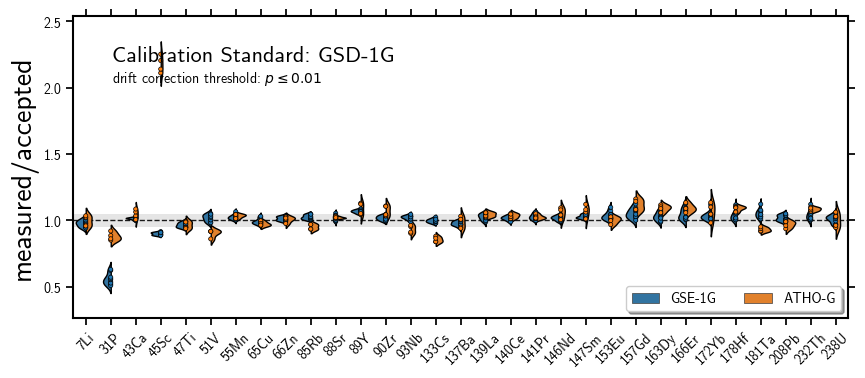

In [16]:
ratios_df = pd.DataFrame(0, index=df_standards.index, columns=myanalytes)

secondary_standards = [
    "GSE-1G",
    "ATHO-G",
]
for standard in secondary_standards:

    for analyte, nomass in zip(myanalytes, myanalytes_nomass):
        if type(df_standards.loc[standard, :]) == pd.Series:
            r = df_standards.loc[standard, analyte] / stds_data.loc[standard, nomass]
            ratios_df.loc[standard, analyte] = r
        else:

            r = (
                df_standards.loc[standard, analyte].to_numpy()
                / stds_data.loc[standard, nomass]
            )
            ratios_df.loc[standard, analyte] = r


fig, ax = plt.subplots(figsize=(10, 4))

ratios_df = ratios_df.loc[secondary_standards, :]
ratios_df_long = ratios_df.reset_index().melt(id_vars="sample", value_vars=myanalytes)


sns.violinplot(
    data=ratios_df_long,
    hue="sample",
    x="variable",
    y="value",
    split=True,
    inner=None,
    linewidth=1,
    edgecolor="k",
    zorder=10,
)
sns.stripplot(
    data=ratios_df_long,
    hue="sample",
    x="variable",
    y="value",
    edgecolor="black",
    jitter=False,
    linewidth=0.5,
    size=3,
)

ax.set_xticklabels(myanalytes, rotation=90)
ax.axhline(1, c="k", ls="--", marker="", zorder=0, lw=1)
ax.axhspan(0.95, 1.05, alpha=0.2, fc="gray", zorder=0)
# ax.set_ylim(0.5, 1.5)
ax.text(
    0.05,
    0.85,
    "Calibration Standard: {}".format(calib_std),
    fontsize=16,
    transform=ax.transAxes,
)
ax.text(
    0.05,
    0.78,
    "drift correction threshold: $p \leq {}$".format(alpha),
    fontsize=10,
    transform=ax.transAxes,
)
ax.minorticks_off()

ax.set_xticklabels(myanalytes, rotation=45)
ax.set_ylabel("measured/accepted", fontsize=20)
ax.set_xlabel("")

for i in range(len(ax.collections)):

    ax.collections[i].set_edgecolor("k")

    # Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(
    handles[0:2], labels[0:2], loc="lower right", ncol=2, fancybox=True, shadow=True
)
# plt.savefig("{}/measured_accepted_plot_{}.png".format(outpath,calib_std),bbox_inches = 'tight')

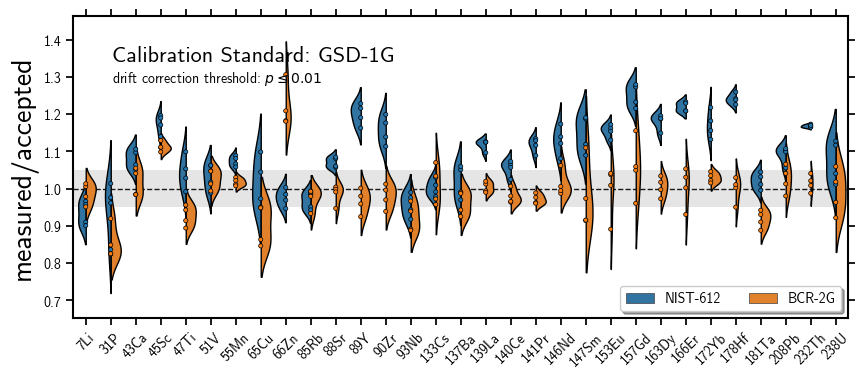

In [17]:
ratios_df = pd.DataFrame(0, index=df_standards.index, columns=myanalytes)

secondary_standards = [
    "NIST-612",
    "BCR-2G",
]
for standard in secondary_standards:

    for analyte, nomass in zip(myanalytes, myanalytes_nomass):
        if type(df_standards.loc[standard, :]) == pd.Series:
            r = df_standards.loc[standard, analyte] / stds_data.loc[standard, nomass]
            ratios_df.loc[standard, analyte] = r
        else:

            r = (
                df_standards.loc[standard, analyte].to_numpy()
                / stds_data.loc[standard, nomass]
            )
            ratios_df.loc[standard, analyte] = r


fig, ax = plt.subplots(figsize=(10, 4))

ratios_df = ratios_df.loc[secondary_standards, :]
ratios_df_long = ratios_df.reset_index().melt(id_vars="sample", value_vars=myanalytes)


sns.violinplot(
    data=ratios_df_long,
    hue="sample",
    x="variable",
    y="value",
    split=True,
    inner=None,
    linewidth=1,
    edgecolor="k",
    zorder=10,
)
sns.stripplot(
    data=ratios_df_long,
    hue="sample",
    x="variable",
    y="value",
    edgecolor="black",
    jitter=False,
    linewidth=0.5,
    size=3,
)

ax.set_xticklabels(myanalytes, rotation=90)
ax.axhline(1, c="k", ls="--", marker="", zorder=0, lw=1)
ax.axhspan(0.95, 1.05, alpha=0.2, fc="gray", zorder=0)
# ax.set_ylim(0.5, 1.5)
ax.text(
    0.05,
    0.85,
    "Calibration Standard: {}".format(calib_std),
    fontsize=16,
    transform=ax.transAxes,
)
ax.text(
    0.05,
    0.78,
    "drift correction threshold: $p \leq {}$".format(alpha),
    fontsize=10,
    transform=ax.transAxes,
)
ax.minorticks_off()

ax.set_xticklabels(myanalytes, rotation=45)
ax.set_ylabel("measured/accepted", fontsize=20)
ax.set_xlabel("")

for i in range(len(ax.collections)):

    ax.collections[i].set_edgecolor("k")

    # Get the handles and labels. For this example it'll be 2 tuples
# of length 4 each.
handles, labels = ax.get_legend_handles_labels()

# When creating the legend, only use the first two elements
# to effectively remove the last two.
l = plt.legend(
    handles[0:2], labels[0:2], loc="lower right", ncol=2, fancybox=True, shadow=True
)
# plt.savefig("{}/measured_accepted_plot_{}.png".format(outpath,calib_std),bbox_inches = 'tight')

# Export concentrations as Excel workbook

In [ ]:
# with pd.ExcelWriter(
#     "my_concentrations.xlsx"
# ) as writer:
#     df_unknowns.to_excel(writer, sheet_name="unknowns")
#     df_standards.to_excel(writer, sheet_name="secondary standards")